In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import math
import time
import random
import datetime
import json
from tensorboard import notebook
from sklearn.model_selection import KFold, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import dlib
import glob
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Concatenate, Dropout, Activation, Add, Input, Dense, Conv2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D, MaxPooling2D, AvgPool2D, Flatten
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
#from monitor_training import MonitorSingleTraining
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from multiprocessing import Queue
import pandas as pd
import scikitplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score

In [2]:
img_path = "../input/ckplus/CK+48"
num_classes = 7
#global total_images = 0
filename_list=["anger", "contempt","disgust", "fear","happy", "sadness", "surprise"]
y_train=[]

In [3]:
# class label dictionaries
CLASS_LABEL_MAP = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Neutral", 5:"Sad", 6:"Surprise"}
LABEL_CLASS_MAP = {"Angry":0, "Disgust":1, "Fear":2, "Happy":3, "Neutral":4, "Sad":5, "Surprise":6}

In [4]:

def load_images(filename_list, width =300, height =300, org_dim=False):
    img_array = []
    
    for i in range(len(filename_list)):
        path=os.path.join(img_path,filename_list[i])
        class_num= filename_list[i]
        if org_dim == True:
            for img in os.listdir(path):
                im = load_img(path=os.path.join(path,img), color_mode="grayscale")
                im = np.array(im)
                im = np.repeat(im[...,np.newaxis],3,-1).reshape((im.shape[0],im.shape[1],3))
                total_images +=1
        else:  
            for img in os.listdir(path):
                #im = load_img(os.path.join(path,img), color_mode="grayscale")
                #im = np.array(im)
                #im = np.repeat(im[...,np.newaxis],3,-1).reshape((im.shape[0],im.shape[1],3))
                im = load_img(path=os.path.join(path,img),target_size=(width,height), color_mode="grayscale")
                im = np.repeat(np.array(im)[...,np.newaxis],3,-1).reshape((width,height,3))
                img_array.append(im)
                #y_train.append(class_num)
                #total_images +=1
        
    return np.array(img_array)

In [5]:
def CLAHE(img,clahe, verbose=False):
    
    equr = clahe.apply(img[:,:,0])
    equg = clahe.apply(img[:,:,1])
    equb = clahe.apply(img[:,:,2])
    equ = np.dstack((equr,equg,equb))
    
    if verbose==True:
        equ_minmax = cv2.normalize(equ, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        for i in range(0,28709):
            img[i] = img[i]/255.0
        for i in range(0,28709):
            equ[i] = equ[i]/255.0    
        plt.imshow(np.hstack((img,equ,equ_minmax)))
        plt.show()
        
    return equ


In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [7]:
def normalize_data(img_data,params={},verbose=False):
    
    normalized_img_data = []
    # contrast limited adaptive histogram equalization
    clahe_transform = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for i in range(img_data.shape[0]):
        normalized_img_data.append(CLAHE(np.array(img_data[i]),clahe_transform,verbose))
        
    normalized_img_data = np.array(normalized_img_data,dtype=np.float32)
    
    return normalized_img_data

In [8]:
img_array_300=load_images(filename_list,300,300)

In [9]:
img_array_300.shape

(981, 300, 300, 3)

In [10]:
normalized_img_array_300 = normalize_data(img_array_300)

In [11]:
normalized_img_array_300.shape

(981, 300, 300, 3)

In [12]:
opencv_dnn_caffe_model = "../input/modelcaffe/deploy.caffemodel"
opencv_dnn_caffe_prototxt = "../input/modelcaffe/deploy.prototxt.txt"
caffe_net = cv2.dnn.readNetFromCaffe(opencv_dnn_caffe_prototxt, opencv_dnn_caffe_model)

In [13]:
def face_crop(img_data):
    face_crop_img_data = []
    for i in range(img_data.shape[0]):
        image1=img_data[i]
        image2=img_data[i]
#         print(image1.shape)
        blob = cv2.dnn.blobFromImage(np.float32(image1), 1.0,(300, 300), (104.0, 117.0, 123.0))
        caffe_net.setInput(blob)
        faces = caffe_net.forward()
        w=300
        h=300  
        for j in range(0, faces.shape[2]):
            box = faces[0, 0, j, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            confidence = faces[0, 0, j, 2]
            if startX>300 or startY>300 or endX>300 or endY>300:
                continue
            if endX<startX or endY<startY:
                continue
              # If confidence > 0.5, show box around face
            flag=False
            if (confidence > 0.5):
                image3 = image1[startY:endY, startX:endX]
                #image1=cv2.resize(image1,(300,300))
                if(image3.shape[0]==0 or image3.shape[1]==0):
                    continue
                #print(image3.shape)
                face_crop_img_data.append(image3)
                flag=True
                break
        if(flag==False):
            face_crop_img_data.append(image2)
    #face_crop_img_data = np.array(face_crop_img_data,dtype=np.uint16)
    
    return face_crop_img_data

In [14]:
face_crop_img_data_300 = face_crop(normalized_img_array_300)

In [15]:
len(face_crop_img_data_300)

981

In [16]:
face_crop_img_data_300 = np.array(face_crop_img_data_300)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [17]:
face_crop=[]
for i in range(face_crop_img_data_300.shape[0]):
    image1=face_crop_img_data_300[i]
    image1=cv2.resize(image1,(48,48))
    face_crop.append(image1)

In [18]:
face_crop_array=np.array(face_crop)

In [19]:
face_crop_array.shape

(981, 48, 48, 3)

In [20]:
face_crop_array = face_crop_array/255.0

## input shuffle and data split

In [21]:
y_train = np.ones((981,),dtype='int64')

y_train[0:134]=0 #135
y_train[135:188]=1 #54
y_train[189:365]=2 #177
y_train[366:440]=3 #75
y_train[441:647]=4 #207
y_train[648:731]=5 #84
y_train[732:980]=6 #249

In [22]:
Y_train = to_categorical(y_train, 7)

In [23]:
#Shuffle the dataset
x,y = shuffle(face_crop_array,Y_train, random_state=2)

In [24]:
X_train, X_test, Y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)

In [25]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = Y_train.shape[1]

In [26]:
classifier_vgg16 = VGG16(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

2022-04-11 06:47:40.423708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 06:47:40.451888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 06:47:40.453089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 06:47:40.455084: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 1s 0us/step


In [27]:
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [28]:
classifier1 = classifier_vgg16.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=7, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [30]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [31]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [32]:
batch_size = 25
epochs = 25
#print("111111111111111111111111111111")
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]
#print("222222222222222222222222222222")
model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)
#print("333333333333333333333333333333")
history = model.fit_generator(
    train_datagen.flow(X_train, Y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/25


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-11 06:47:44.648811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-11 06:47:46.133141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 8s 53ms/step - loss: 1.9119 - accuracy: 0.3637 - val_loss: 1.4620 - val_accuracy: 0.3919
Epoch 2/25
33/33 [==============================] - 1s 28ms/step - loss: 1.4886 - accuracy: 0.4706 - val_loss: 1.2602 - val_accuracy: 0.5338
Epoch 3/25
33/33 [==============================] - 1s 29ms/step - loss: 1.4208 - accuracy: 0.5042 - val_loss: 1.1536 - val_accuracy: 0.5811
Epoch 4/25
33/33 [==============================] - 1s 29ms/step - loss: 1.3908 - accuracy: 0.5126 - val_loss: 1.2545 - val_accuracy: 0.5203
Epoch 5/25
33/33 [==============================] - 1s 33ms/step - loss: 1.3575 - accuracy: 0.5198 - val_loss: 1.1807 - val_accuracy: 0.5811
Epoch 6/25
33/33 [==============================] - 1s 31ms/step - loss: 1.3958 - accuracy: 0.4934 - val_loss: 1.2067 - val_accuracy: 0.5811
Epoch 7/25
33/33 [==============================] - 1s 28ms/step - loss: 1.3536 - accuracy: 0.5138 - val_loss: 1.1512 - val_accuracy: 0.5811

Epoch 00007: ReduceLROn

In [33]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.9032878279685974
Test accuracy: 0.6554054021835327


In [34]:
model.save("model_vgg16.h5")

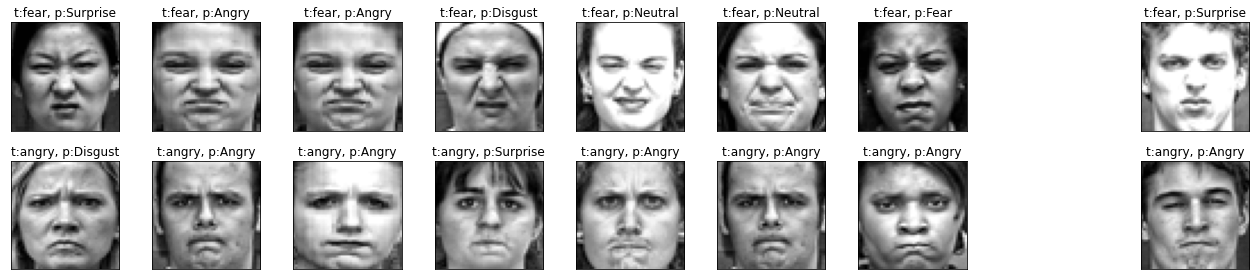

In [35]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, LABEL_CLASS_MAP["Fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, LABEL_CLASS_MAP["Angry"]]==1)[0], size=9, replace=False)

fig = plt.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = CLASS_LABEL_MAP[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = CLASS_LABEL_MAP[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        plt.tight_layout()


In [36]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

In [37]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==LABEL_CLASS_MAP[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==LABEL_CLASS_MAP[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = plt.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = CLASS_LABEL_MAP[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")

total 9 miss labels out of 10 for emotion Happy


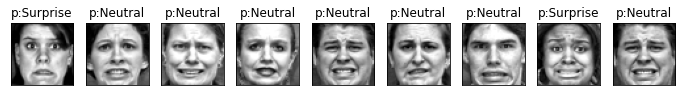

In [38]:
plot_miss_classified(emotion="Happy")

total 21 miss labels out of 32 for emotion Fear


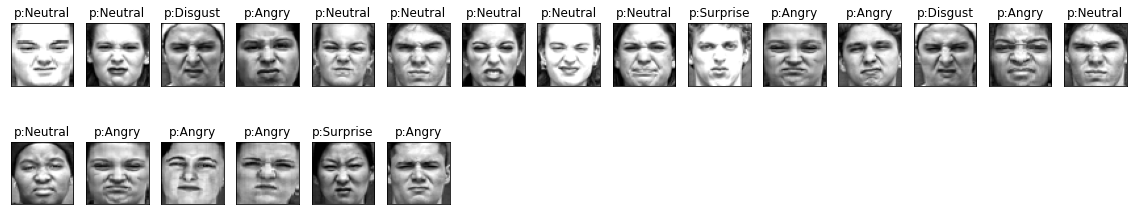

In [39]:
plot_miss_classified(emotion="Fear")

total 5 miss labels out of 20 for emotion Angry


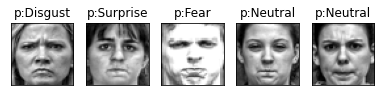

In [40]:
plot_miss_classified(emotion="Angry")

total 1 miss labels out of 23 for emotion Neutral


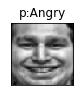

In [41]:
plot_miss_classified(emotion="Neutral")

total 5 miss labels out of 7 for emotion Disgust


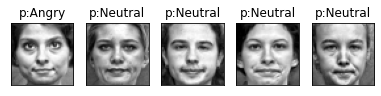

In [42]:
plot_miss_classified(emotion="Disgust")

total 2 miss labels out of 47 for emotion Surprise


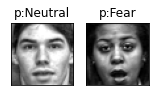

In [43]:
plot_miss_classified(emotion="Surprise")

total 8 miss labels out of 9 for emotion Sad


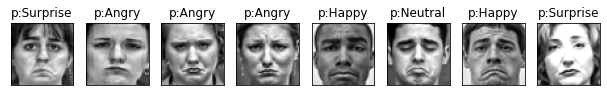

In [44]:
plot_miss_classified(emotion="Sad")

In [45]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [46]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# tfLite Model

In [47]:
KERAS_MODEL_NAME = "model_vgg16.h5"

In [48]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 57.739 Megabytes


In [49]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [50]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

2022-04-11 06:48:36.048072: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-04-11 06:48:37.889007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 06:48:37.889471: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-04-11 06:48:37.889623: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-04-11 06:48:37.890051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 06:48:37.890512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne

In [51]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [52]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model_quant)

14973624

In [53]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")

File size: 14.28 Megabytes


In [54]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

  # Initialize the interpreter
    interpreter = tf.lite.Interpreter(tflite_file)
    interpreter.allocate_tensors()
    #X_train, X_test, Y_train, y_test
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = X_test[test_image_index]
        test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()
    print(predictions)
    return predictions


In [55]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels

    test_image_indices = range(X_test.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)
    print("**************************")
    #print(predictions)
    #predictions = to_categorical(predictions, 7)
    return predictions

In [56]:
result=evaluate_model(TF_LITE_MODEL_FILE_NAME, model_type="Quantized")

[0 4 6 6 4 0 6 6 4 0 4 4 4 4 6 4 0 6 4 4 2 6 6 4 4 4 6 0 0 6 4 0 6 3 4 2 2
 4 0 0 3 6 6 6 4 0 6 6 6 6 6 0 3 2 4 6 1 6 4 4 4 6 4 6 4 2 0 2 4 4 4 3 4 6
 0 1 2 0 6 6 4 4 6 6 2 6 6 6 6 4 4 0 0 4 6 0 6 4 6 1 6 0 0 6 0 0 4 0 4 4 6
 6 2 4 6 6 4 0 0 4 6 2 0 0 4 4 6 4 0 6 6 2 4 0 6 2 4 6 4 6 2 6 1 4 6 5 6 0]
**************************


In [57]:
result = to_categorical(result, 7)

In [58]:
count=0
for i in range(148):
    if(result[i].argmax() ==y_test[i].argmax()):
        count+=1
        

In [59]:
accuracy=(count/148)*100

In [60]:
print("int8 accuracy is %d", accuracy)

int8 accuracy is %d 64.86486486486487
